In [4]:
import pandas as pd
import numpy as np

pd.options.display.width = 200
pd.options.display.max_columns = 20

# Import Almond.csv
almond: pd.DataFrame = pd.read_csv('Almond.csv')
almond.columns = ['idx', 'len', 'wid', 'thk', 'area', 'perim', 'round', 'solid', 'compact', 'aspect', 'eccent', 'extent', 'convex', 'type']

#=============== PREPROCESSING ===============#

# Remove useless/redundant cols
almond = almond.drop(['idx', 'round', 'aspect', 'eccent'], axis=1)

# Isolate len, wid, thk cols + convert to numeric
dims: pd.DataFrame = almond[['len', 'wid', 'thk']]

# Convert to numeric
dims = dims.apply(pd.to_numeric, errors='coerce')

# Replace missing values with -1
dims = dims.fillna(-1)

# Create one-hot encoding for missing values
dimsOneHot = dims.copy()
dimsOneHot[dimsOneHot != -1] = 0
dimsOneHot[dimsOneHot == -1] = 1
dimsOneHot.columns = ['len1H', 'wid1H', 'thk1H']

print("-"*50 + " dims " + "-"*50)
print(dims.head(n=20))

print("-"*50 + " dimsOneHot " + "-"*50)
print(dimsOneHot.head(n=20))

# Sort within row + delete first col (empty after sort)
dimsSorted: pd.Series = dims.apply(np.sort, axis=1)
dims = pd.DataFrame(dimsSorted.values.tolist(), index=dimsSorted.index, columns=['null', 'len', 'wid'])
dims = dims[['len', 'wid']]

# Replace len, wid, thk cols in almond with sorted values
almond[['len', 'wid']] = dims
almond.drop('thk', axis=1, inplace=True)

# Insert one-hot encoding for missing values
almond.insert(2, 'thk1H', dimsOneHot['thk1H'])
almond.insert(2, 'wid1H', dimsOneHot['wid1H'])
almond.insert(2, 'len1H', dimsOneHot['len1H'])
almond[['len1H', 'wid1H', 'thk1H']] = dimsOneHot

# Convert area, perim, solid, compact, extent, convex to numeric
almond[['area', 'perim', 'solid', 'compact', 'extent', 'convex']] = almond[['area', 'perim', 'solid', 'compact', 'extent', 'convex']].apply(pd.to_numeric)

# Convert type to one-hot encoding
typeOneHot = pd.get_dummies(almond['type'])
typeOneHot.columns = ['mamra', 'regular', 'sanora']
# almond = almond.drop('type', axis=1)
# almond = almond.join(typeOneHot.astype(float))

# Split to X, Y
X = almond.drop('type', axis=1)
Y = typeOneHot.astype(float)

# Print fully preprocessed dataset
print("-"*50 + " Inputs (X) - fully preprocessed " + "-"*50)
print(X)
print("-"*50 + " Targets (Y) - fully preprocessed " + "-"*50)
print(Y)

-------------------------------------------------- dims --------------------------------------------------
           len         wid         thk
0    -1.000000  227.940628  127.759132
1    -1.000000  234.188126  128.199509
2    -1.000000  229.418610  125.796547
3    -1.000000  232.763153  125.918808
4    -1.000000  230.150742  107.253448
5    -1.000000  231.914429  107.759789
6    -1.000000  226.371048  106.479408
7    -1.000000  226.186142  102.623077
8   413.477173   -1.000000  138.190536
9   418.210327   -1.000000  129.659897
10  423.226959   -1.000000  123.572952
11  416.757172   -1.000000  131.968613
12  372.898560   -1.000000  100.815842
13  364.393768   -1.000000   98.433388
14  360.413147   -1.000000   99.454498
15  362.050964   -1.000000   95.933342
16  315.512085  169.067093   -1.000000
17  318.522736  168.491837   -1.000000
18  320.810455  168.278076   -1.000000
19  317.151794  167.854141   -1.000000
-------------------------------------------------- dimsOneHot ------------

In [ ]:
import tensorflow as tf
import tensorboard.keras as keras
# import keras
import numpy
Sequential              = keras.models.Sequential
Dense                   = keras.layers.Dense
Input                   = keras.layers.Input
Optimizer               = keras.optimizers.Optimizer
CategoricalCrossentropy = keras.losses.CategoricalCrossentropy
CategoricalAccuracy     = keras.metrics.CategoricalAccuracy
K                       = keras.backend

# See: [https://github.com/ntnu-ai-lab/RProp/blob/master/rprop.py]
__name__ = "rprop"

class RProp(Optimizer):
    def __init__(self, init_alpha=1e-3, scale_up=1.2, scale_down=0.5, min_alpha=1e-6, max_alpha=50., **kwargs):
        super(RProp, self).__init__(**kwargs, name="Rprop")
        self.init_alpha = K.variable(init_alpha, name='init_alpha')
        self.scale_up = K.variable(scale_up, name='scale_up')
        self.scale_down = K.variable(scale_down, name='scale_down')
        self.min_alpha = K.variable(min_alpha, name='min_alpha')
        self.max_alpha = K.variable(max_alpha, name='max_alpha')
        self._learning_rate = 0.001

    def get_updates(self, params, loss):
        grads = self.get_gradients(loss, params)
        shapes = [K.get_variable_shape(p) for p in params]
        alphas = [K.variable(numpy.ones(shape) * self.init_alpha) for shape in shapes]
        old_grads = [K.zeros(shape) for shape in shapes]
        prev_weight_deltas = [K.zeros(shape) for shape in shapes]
        self.weights = alphas + old_grads
        self.updates = []

        for param, grad, old_grad, prev_weight_delta, alpha in zip(params, grads,
                                                                   old_grads, prev_weight_deltas,
                                                                   alphas):
            # equation 4
            new_alpha = K.switch(
                K.greater(grad * old_grad, 0),
                K.minimum(alpha * self.scale_up, self.max_alpha),
                K.switch(K.less(grad * old_grad, 0), K.maximum(alpha * self.scale_down, self.min_alpha), alpha)
            )

            # equation 5
            new_delta = K.switch(K.greater(grad, 0),
                                 -new_alpha,
                                 K.switch(K.less(grad, 0),
                                          new_alpha,
                                          K.zeros_like(new_alpha)))

            # equation 7
            weight_delta = K.switch(K.less(grad*old_grad, 0), -prev_weight_delta, new_delta)

            # equation 6
            new_param = param + weight_delta

            # reset gradient_{t-1} to 0 if gradient sign changed (so that we do
            # not "double punish", see paragraph after equation 7)
            grad = K.switch(K.less(grad*old_grad, 0), K.zeros_like(grad), grad)


            # Apply constraints
            #if param in constraints:
            #    c = constraints[param]
            #    new_param = c(new_param)

            self.updates.append(K.update(param, new_param))
            self.updates.append(K.update(alpha, new_alpha))
            self.updates.append(K.update(old_grad, grad))
            self.updates.append(K.update(prev_weight_delta, weight_delta))

        return self.updates

    def get_config(self):
        config = {
            'init_alpha': float(K.get_value(self.init_alpha)),
            'scale_up': float(K.get_value(self.scale_up)),
            'scale_down': float(K.get_value(self.scale_down)),
            'min_alpha': float(K.get_value(self.min_alpha)),
            'max_alpha': float(K.get_value(self.max_alpha)),
        }
        base_config = super(RProp, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

ModuleNotFoundError: No module named 'tensorboard.keras'

In [37]:
Adam = tf.keras.optimizers.Adam

model = Sequential([
    Input(shape=(11,)),  # 11 input features
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')  # 3 output classes
])

model.compile(optimizer=RProp(),
              loss=CategoricalCrossentropy(),
              metrics=[CategoricalAccuracy()])

model.fit(X, Y, epochs=100, batch_size=32)

Epoch 1/100


NotImplementedError: in user code:

    File "/home/rec1dite/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/rec1dite/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/rec1dite/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/rec1dite/.local/lib/python3.8/site-packages/keras/engine/training.py", line 1027, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/rec1dite/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
        self.apply_gradients(grads_and_vars)
    File "/home/rec1dite/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
        return super().apply_gradients(grads_and_vars, name=name)
    File "/home/rec1dite/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
        iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/rec1dite/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
        return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/rec1dite/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
        distribution.extended.update(
    File "/home/rec1dite/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1213, in apply_grad_to_update_var  **
        return self._update_step(grad, var)
    File "/home/rec1dite/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 224, in _update_step
        self.update_step(gradient, variable)
    File "/home/rec1dite/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 188, in update_step
        raise NotImplementedError

    NotImplementedError: 


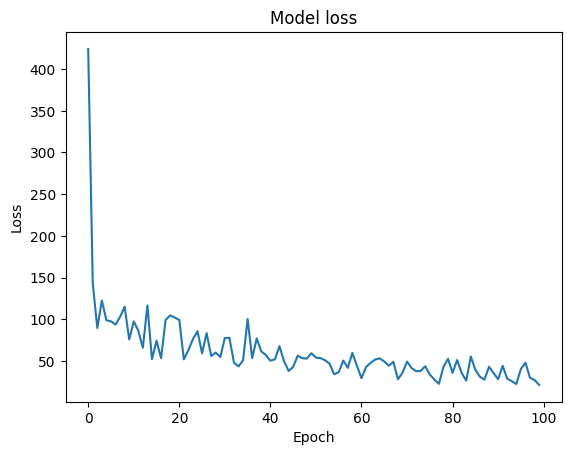

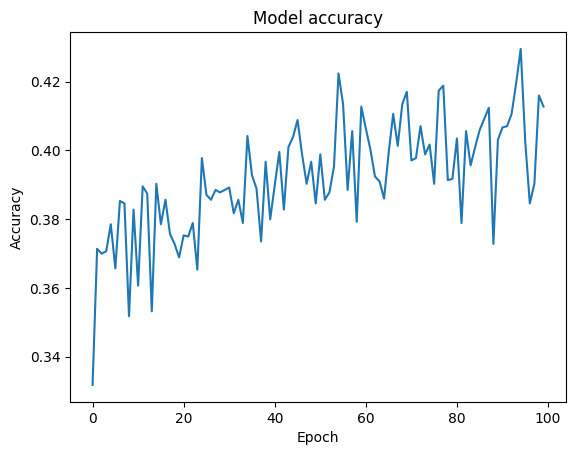

In [24]:
# Plot results
import matplotlib.pyplot as plt

plt.plot(model.history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(model.history.history['categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

# Save model
# model.save('almond_classifier.h5')

# # Load model
# loaded_model = tf.keras.models.load_model('almond_classifier.h5')

# # Test model
# test = pd.DataFrame({
#     'len': [3.5],
#     'wid': [3.5],
#     'area': [12.25],
#     'perim': [14],
#     'solid': [0.8],
#     'compact': [0.8],
#     'extent': [0.8],
#     'convex': [0.8],
#     'len1H': [0],
#     'wid1H': [0],
#     'thk1H': [0]
# })

# print(loaded_model.predict(test))